 # Linear Regression and Seasonality Modeling

 In this script, we will:

 - Fit a **Linear Regression** model to each beam's throughput volume (`thp_vol`) using only **time** as the feature.

 - Calculate the **residuals**, scaled down by the linear predictions.

 - Apply a seasonality model to these residuals using engineered features.

 - Combine the predictions from both models to get the final prediction.



 This method is an example of **Model Stacking** or **Residual Modeling**, where we use one model to capture the main trend and another to model the residuals.

 ## Imports and Setup

In [71]:
# %%
import os
import logging
from pathlib import Path

import numpy as np
import polars as pl
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import wandb
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

# Load utility functions (assuming utils.py is in the same directory)
import utils

# Manually set the notebook name for W&B
os.environ["WANDB_NOTEBOOK_NAME"] = "train_w10_w11.ipynb"

# Set up logging
logging.basicConfig(level=logging.INFO)


 ## Configuration

In [72]:
# %%
# Set DEBUG mode
DEBUG = False

# Load configuration from YAML file
config_file_path = Path('configs') / 'seasonality_config.yaml'
with open(config_file_path, 'r') as file:
    config = yaml.safe_load(file)


 ## Data Loading

In [73]:
# %%
# Read the CSV files
data_dir = Path('input-data')
thp_vol_df = pl.read_csv(data_dir / 'traffic_DLThpVol.csv')
idx_hour_series = thp_vol_df['']
thp_vol_df = thp_vol_df.drop('')

# If in DEBUG mode, shorten dataframes
if DEBUG:
    thp_vol_df = thp_vol_df.head(200).select(thp_vol_df.columns[:800])
    idx_hour_series = idx_hour_series.head(200)


 ## Data Preprocessing

In [74]:
# %%
# Convert idx_hour_series to Polars DataFrame
time_df = pl.DataFrame({'time': idx_hour_series})

# Combine time and thp_vol_df
data_df = pl.concat([time_df, thp_vol_df], how='horizontal')


 ## Initialize W&B

In [75]:
# %%
# Initialize W&B
run = wandb.init(
    project="traffic-forecasting-challenge",
    job_type='train',
    entity="esedx12",
    config=config,
    save_code=True,
    mode=('disabled' if DEBUG else 'online')
)


 ## Linear Regression Model

In [76]:
# %%
# Split into train and test sets based on time
train_percentage = config['train_percentage']
num_rows = data_df.height
num_train_rows = int(num_rows * train_percentage)

train_df = data_df[:num_train_rows]
test_df = data_df[num_train_rows:]

# Features and targets
X_train_linear = train_df.select(['time'])
Y_train = train_df.drop('time')

X_test_linear = test_df.select(['time'])
Y_test = test_df.drop('time')

# Fit multi-output linear regression
logging.info("Training the multi-output linear regression model...")

# Fit the model
linear_model = LinearRegression()
linear_model.fit(X_train_linear, Y_train)

INFO:root:Training the multi-output linear regression model...


LinearRegression()

 ## Calculate Residuals

In [77]:
# %%
# Predict on training and test sets
logging.info("Calculating residuals...")
Y_train_pred = linear_model.predict(X_train_linear)
# Y_test_pred = linear_model.predict(X_test_linear)

# Convert predictions back to Polars DataFrame
Y_train_pred_df = pl.DataFrame(Y_train_pred)
Y_train_pred_df.columns = Y_train.columns

# Y_test_pred_df = pl.DataFrame(Y_test_pred)
# Y_test_pred_df.columns = Y_test.columns

# Calculate residuals scaled by the linear prediction
# Avoid division by zero by adding a small epsilon
epsilon = 1e-8
Y_train_pred_df

train_residuals = (Y_train - Y_train_pred_df) / (Y_train_pred_df)
# test_residuals = (Y_test - Y_test_pred_df) / (Y_test_pred_df + epsilon)


INFO:root:Calculating residuals...


## Scale down

In [78]:
# Option to scale down coefficients by a value DOWNSCALER
DOWNSCALER = config['downscaler']
linear_model.coef_ = linear_model.coef_ * DOWNSCALER
print(f"Downscaled coefficients by {DOWNSCALER}")

Downscaled coefficients by 0.5


shape: (1_848, 2_880)
┌──────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ 0_0_0    ┆ 0_0_1    ┆ 0_0_2    ┆ 0_0_3    ┆ … ┆ 29_2_28  ┆ 29_2_29  ┆ 29_2_30  ┆ 29_2_31  │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 0.400505 ┆ 0.227326 ┆ 0.209757 ┆ 0.067087 ┆ … ┆ 0.059365 ┆ 0.066673 ┆ 0.129431 ┆ 0.102332 │
│ 0.400632 ┆ 0.227322 ┆ 0.209745 ┆ 0.067081 ┆ … ┆ 0.059362 ┆ 0.066693 ┆ 0.129439 ┆ 0.102317 │
│ 0.400759 ┆ 0.227318 ┆ 0.209734 ┆ 0.067076 ┆ … ┆ 0.059359 ┆ 0.066714 ┆ 0.129447 ┆ 0.102302 │
│ 0.400886 ┆ 0.227315 ┆ 0.209723 ┆ 0.067071 ┆ … ┆ 0.059356 ┆ 0.066734 ┆ 0.129454 ┆ 0.102287 │
│ 0.401012 ┆ 0.227311 ┆ 0.209712 ┆ 0.067066 ┆ … ┆ 0.059353 ┆ 0.066754 ┆ 0.129462 ┆ 0.102272 │
│ …        ┆ …        ┆ …        ┆ …  

<Axes: >

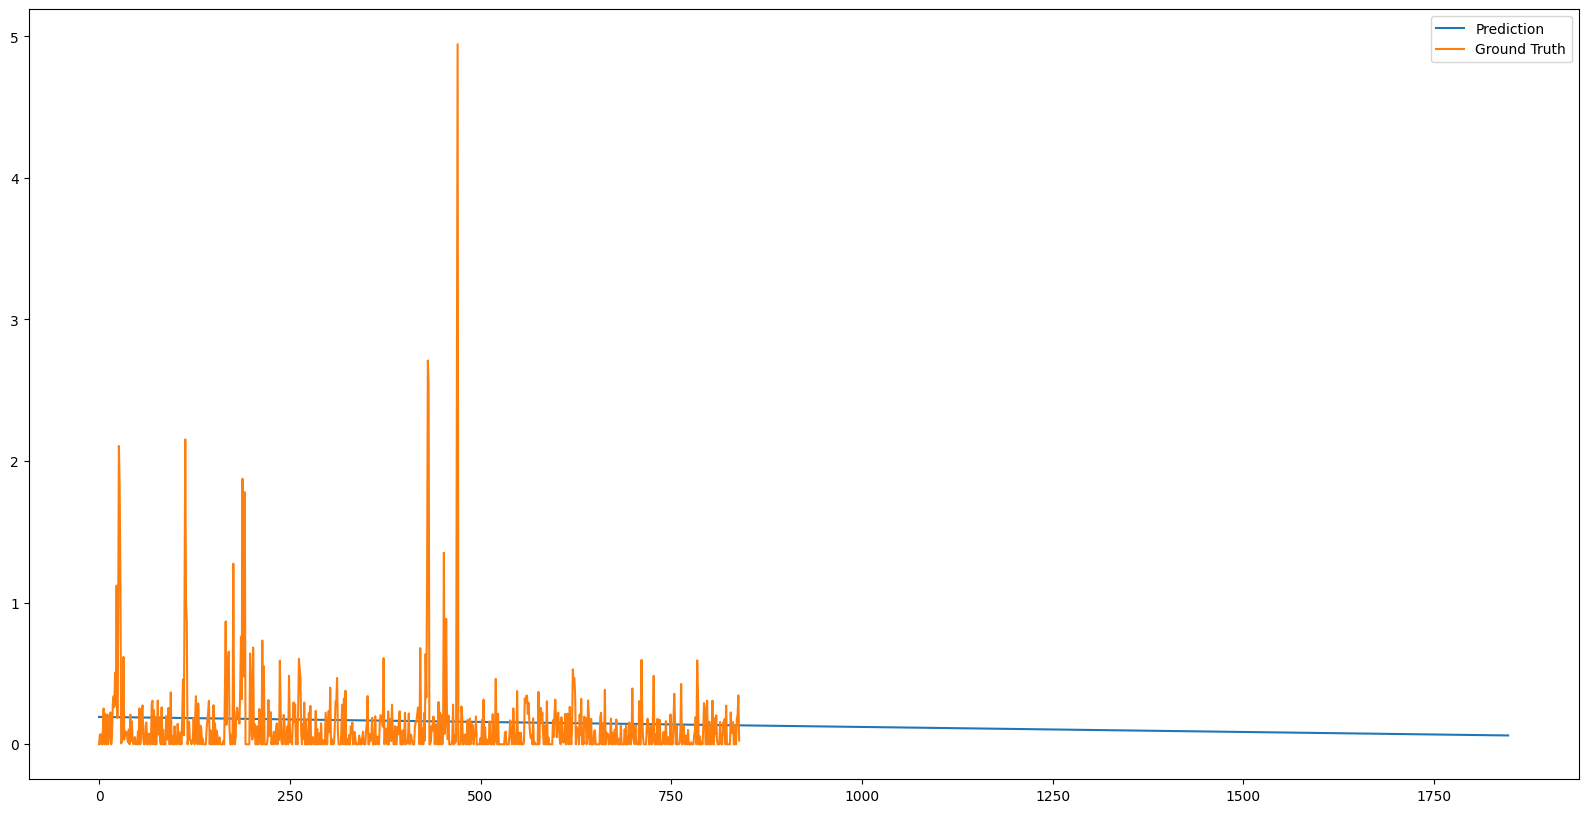

In [79]:
long_time = pl.DataFrame({'time': list(range(0, 168 * 11))})
long_time_linear_pred = pl.DataFrame(linear_model.predict(long_time), schema=Y_train.schema)
print(long_time_linear_pred)
# check on what columns there are negatie entries at last row and count them by getting last row and counting negative entries
last_row = list(long_time_linear_pred.row(-1))
num_negatives = sum([1 for i in last_row if i < 0])
print(f"Number of negative entries in last row: {num_negatives}")

# plot first col with ground truth overlaid with sns
plt.figure(figsize=(20, 10))
sns.lineplot(data=long_time_linear_pred['0_0_27'], label='Prediction')
sns.lineplot(data=Y_train['0_0_27'], label='Ground Truth')

 ## Seasonality Model for Residuals

In [95]:
# %%
# Calculate seasonality component by taking the median value of the residuals for each hour across the four weeks
logging.info("Calculating seasonality component...")

# Assuming we have 4 weeks of hourly data (4 * 168 rows)
n_hours_in_week = 168
num_weeks = 5

# Reshape the residuals data to calculate the median per hour
reshaped_train_residuals = train_residuals.to_pandas().values.reshape(num_weeks, n_hours_in_week, -1)

# sort every dim 0 series
reshaped_train_residuals = np.sort(reshaped_train_residuals, axis=0)

seasonality_typical = np.average(reshaped_train_residuals, weights=[0, 0.3, 0.4, 0.3, 0], axis=0)
# seasonality_typical = np.average(reshaped_train_residuals, weights=[0, 0, 1, 0, 0], axis=0)
# seasonality_typical = np.median(reshaped_train_residuals, axis=0)

# Convert the seasonality medians back to a Polars DataFrame
seasonality_df = pl.DataFrame(seasonality_typical)
seasonality_df.columns = Y_train.columns

# Final prediction will be updated once the seasonality model is combined


INFO:root:Calculating seasonality component...


<Axes: >

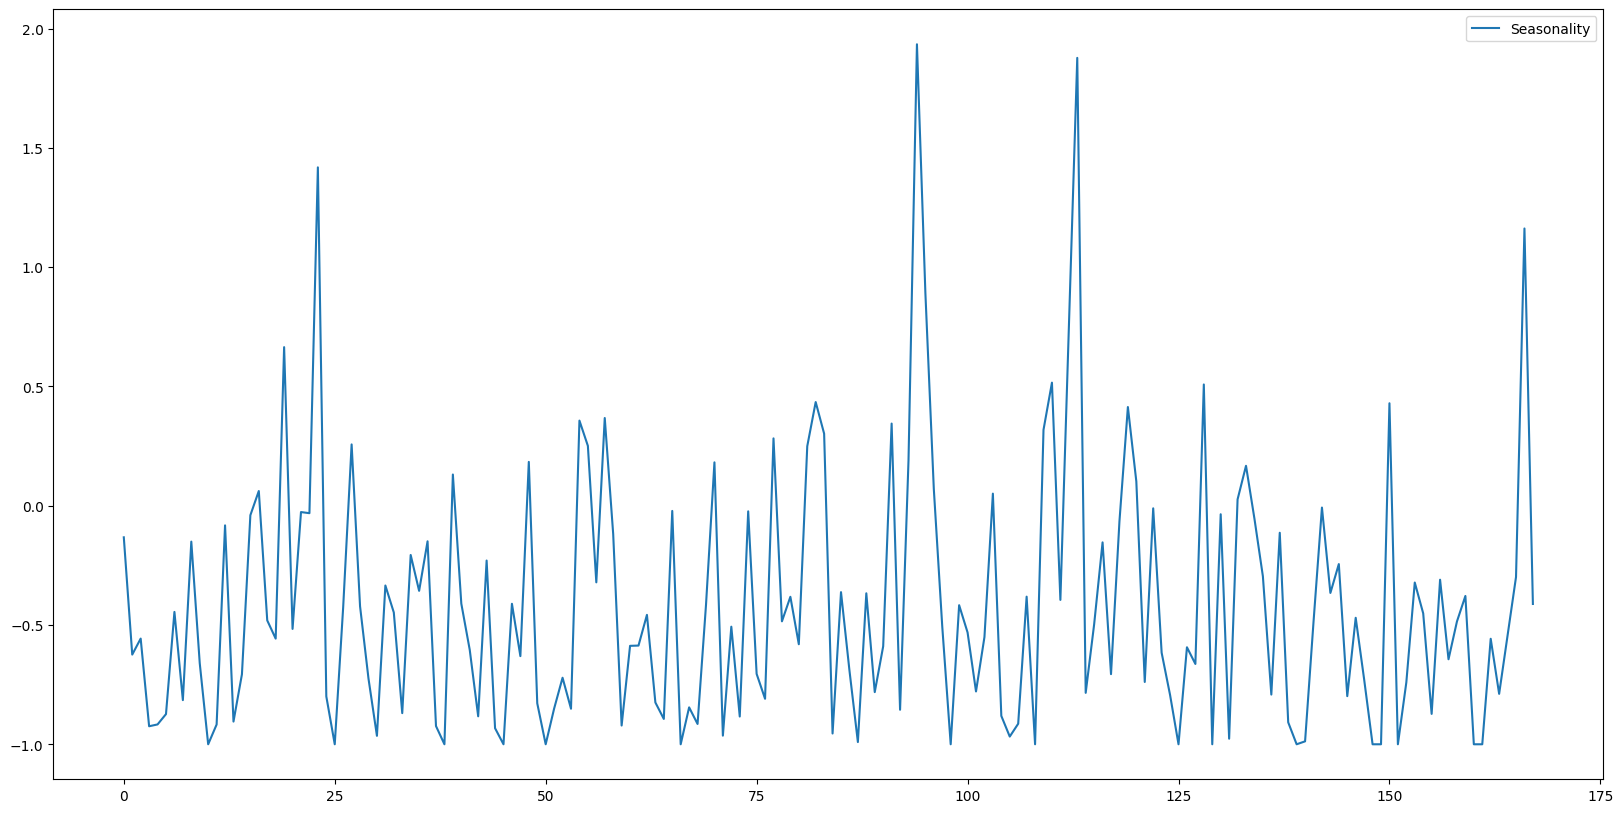

In [96]:
# plot seasonality component
plt.figure(figsize=(20, 10))
sns.lineplot(data=seasonality_df['0_0_27'], label='Seasonality')

 ## Combine Predictions

In [10]:
# %%
Y_test_pred_df_downscaled = linear_model.predict(X_test_linear)
# Combine predictions from Linear Regression and Seasonality Model
logging.info("Combining predictions from Linear Regression and Seasonality model...")
# Scale back up the median residuals by the linear prediction
scaled_seasonality = seasonality_df.to_numpy() * (Y_test_pred_df + epsilon)
Y_test_final_pred = Y_test_pred_df.values + scaled_seasonality


INFO:root:Combining predictions from Linear Regression and Seasonality model...


AttributeError: 'DataFrame' object has no attribute 'values'

In [ ]:
final_pred = max(pred, 0)

 ## Evaluation

In [ ]:
# %%
# Calculate metrics
logging.info("Evaluating the combined model...")
test_mae = mean_absolute_error(Y_test.values, Y_test_final_pred, multioutput='raw_values')
test_mse = mean_squared_error(Y_test.values, Y_test_final_pred, multioutput='raw_values')

# Calculate average metrics
avg_test_mae = np.mean(test_mae)
avg_test_mse = np.mean(test_mse)

# Log average metrics to W&B
wandb.log({
    'avg_test_mae': avg_test_mae,
    'avg_test_mse': avg_test_mse
})

logging.info(f"Average Test MAE: {avg_test_mae:.4f}")
logging.info(f"Average Test MSE: {avg_test_mse:.4f}")


 ## Save the Models

In [ ]:
# %%
# Save the linear model
model_dir = Path('checkpoints') / wandb.run.name
model_dir.mkdir(parents=True, exist_ok=True)

import pickle
linear_model_path = model_dir / 'linear_model.pkl'
with open(linear_model_path, 'wb') as f:
    pickle.dump(linear_model, f)

# Save model to W&B
wandb.save(str(linear_model_path))


 ## Plotting Predictions vs Actuals for Sample Beams

In [ ]:
# %%
# Sample beams to plot
sample_beams = Y_test.columns[:2]  # Choose two sample beams

for beam in sample_beams:
    # Get actual and predicted values for the beam
    beam_Y_test = Y_test[beam].values
    beam_Y_test_pred = Y_test_final_pred[:, Y_test.columns.get_loc(beam)]
    time_test = X_test_linear['time'].values

    plt.figure(figsize=(14, 6))
    plt.plot(time_test, beam_Y_test, label='Actual', color='blue')
    plt.plot(time_test, beam_Y_test_pred, label='Predicted', color='orange', linestyle='--')
    plt.title(f'Predictions vs Actuals for Beam: {beam}')
    plt.xlabel('Time')
    plt.ylabel('Throughput Volume')
    plt.legend()
    plt.tight_layout()
    
    # Save plot to W&B
    plot_path = f"beam_{beam}_prediction_plot.png"
    plt.savefig(plot_path)
    wandb.log({f"Prediction Plot for Beam {beam}": wandb.Image(plot_path)})
    plt.show()


 ## Finish W&B Run

In [ ]:
# %%
wandb.finish()